Time:  2.4103429317474365
Correlation:  (0.9256028050071942, 6.586928549458607e-16)
Polar_ts trend:  0.6389194729158078
Dyn :  0.5291494857567837
Non Dyn :  0.10976998715902407
Dyn + Non-Dyn:  0.6389194729158078


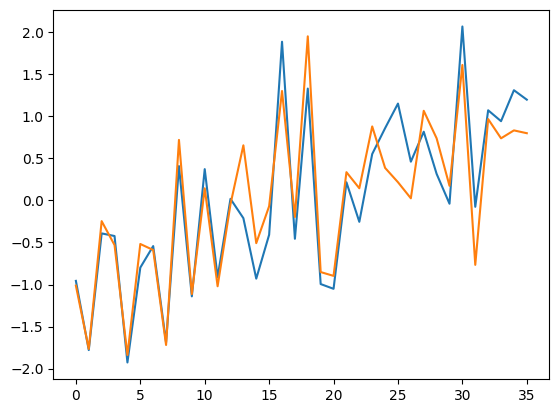

In [28]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import time 

# Set up cartopy shape file so that it can distinguish between land and ocean
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    """
    Uses knowledge of land points to decide whether given location 
    is land or ocean. X is longitude and Y is latitude.
    """
    return land.contains(sgeom.Point(x, y))*1


def find_avg_ts(xarray, land_ocean_map):
    latitudes = xarray.latitude.values
    weights = np.cos(np.deg2rad(latitudes))
    weights_map = np.broadcast_to(weights, (144,73)).T
    temps = xarray.t2m.values
    temps_land = np.array([np.ma.masked_array(data=temps[i], mask=abs(land_ocean_map-1), fill_value=np.nan).filled() for i in range(len(temps))])
    land_weights = np.ma.masked_array(data=weights_map, mask=abs(land_ocean_map-1), fill_value=np.nan).filled()
    weighted_temps = np.multiply(temps_land, weights[np.newaxis, :, np.newaxis])
    weighted_temps_polar = weighted_temps[:,:21,:] # this gives north of 40    
    weighted_temps_polar = np.reshape(weighted_temps_polar, (432, 21*144))
    polar_temp_ts = np.nansum(weighted_temps_polar, axis=1)/np.nansum(land_weights[:21])
    polar_cal = np.reshape(polar_temp_ts, (36,12))
    polar_anoms = polar_cal - np.nanmean(polar_cal, axis=0)
    polar_anoms = np.reshape(polar_anoms, (432))
    polar_cal_ndjfma = np.nanmean([polar_cal[:,10], polar_cal[:,11], polar_cal[:,0], polar_cal[:,1], polar_cal[:,2], polar_cal[:,3]], axis=0)
    return(polar_cal_ndjfma)    

def find_corr_map(slp_map, ts):
    corr_map = []
    for lat in range(len(slp_map[0])):
        lat_row = []
        for lon in range(len(slp_map[0][0])):
            slp_ts = slp_map[:,lat,lon]
            correlation = stats.pearsonr(slp_ts, ts)[0]
            lat_row.append(correlation)
        corr_map.append(lat_row)
    return(np.array(corr_map))

# load datasets 
MonthlyNCEPpsl = xr.open_dataset('/home/disk/pna2/aodhan/MonthlyPSLNCEP.nc', decode_times=False)
MonthlyERA5tas = xr.open_dataset('/home/disk/pna2/aodhan/insitu_surface_products/ERA5_TAS_monthly_1965_2000.nc')

# swap the time axis on the SLP data
times = []
for yr in range(1949, 2024):
    if yr < 2023:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            date_time_obj = pd.to_datetime(str(yr) + '-' + month)
            times.append(date_time_obj)
    if yr == 2023:
        for month in ['01']:
            date_time_obj = pd.to_datetime(str(yr) + '-' + month)
            times.append(date_time_obj)
MonthlyNCEPpsl = MonthlyNCEPpsl.assign_coords(T=times)
MonthlyNCEPpsl_1965_2000 = MonthlyNCEPpsl.sel(T=slice('1965-01-01', '2000-12-01'))

# find land ocean map
land_ocean_map = []
for lat in MonthlyERA5tas.latitude:
    lat_line = []
    for lon in MonthlyERA5tas.longitude - 180:
        lat_line.append(is_land(lon, lat))
    land_ocean_map.append(lat_line)
land_ocean_map = np.array(land_ocean_map)
land_ocean_map = np.concatenate((land_ocean_map[:,72:], land_ocean_map[:,:72]), axis=1)

# find average wintertime temperature timeseries in polar region
polar_ts = find_avg_ts(MonthlyERA5tas, land_ocean_map)
polar_ts_mr = polar_ts - np.nanmean(polar_ts)
polar_ts_std = polar_ts_mr/np.nanstd(polar_ts_mr)

# find wintertime maps of slp
psl_all = MonthlyNCEPpsl_1965_2000.pressure.values
psl_cal = np.reshape(psl_all, (36,12,73,144))
psl_ndjfm = [psl_cal[:,10], psl_cal[:,11], psl_cal[:,0], psl_cal[:,1], psl_cal[:,2], psl_cal[:,3]]
psl_ndjfm = np.nanmean(psl_ndjfm, axis=0)
psl_cal_N = psl_ndjfm[:,:29,:]
psl_cal_N_mr = psl_cal_N - np.nanmean(psl_cal_N, axis=0)
psl_cal_N_std = psl_cal_N_mr/np.nanstd(psl_cal_N_mr, axis=0)

# find weighted
latitudes = MonthlyERA5tas.latitude.values
weights = np.cos(np.deg2rad(latitudes))[:29]
psl_cal_N_weighted = np.multiply(psl_cal_N_std, weights[np.newaxis,:,np.newaxis])

start = time.time()
def dynamic_adjustment(n_comps, X, Y):
    recreations_Y = []
    recreations_X = []
    for iteration in range(n_comps):
        # find correlation map
        correlation_map = find_corr_map(X, Y)

        # project onto correlation map
        projection = np.array([np.nansum(np.multiply(X[i], correlation_map)) for i in range(0, len(X))])
        regression_ts = stats.linregress(x=projection, y=Y)
        recreation_ts = regression_ts[0]*projection + regression_ts[1]
        recreation_psl = []
        for lat_idx in range(len(X[0])):
            lat_line = []
            for lon_idx in range(len(X[0][0])):
                psl_ts_regression = stats.linregress(x=projection, y=X[:,lat_idx, lon_idx])
                pls_recreation = psl_ts_regression[0]*projection + psl_ts_regression[1]
                lat_line.append(pls_recreation)
            recreation_psl.append(lat_line)
        recreation_psl = np.array(recreation_psl)
        recreation_psl = np.swapaxes(recreation_psl, 0, 2)
        recreation_psl = np.swapaxes(recreation_psl, 1, 2)  
        recreations_X.append(recreation_psl)
        recreations_Y.append(recreation_ts)
        regressed_out_X = X - recreation_psl
        regressed_out_Y = Y - recreation_ts
        X = regressed_out_X
        Y = regressed_out_Y
    return(recreations_X, recreations_Y)

Y = polar_ts_std.copy()
X = psl_cal_N_weighted.copy()


recreations_Y = []
recreations_X = []
for x in range(2):
    # find correlation map
    correlation_map = find_corr_map(X, Y)

    # project onto correlation map
    projection = np.array([np.nansum(np.multiply(X[i], correlation_map)) for i in range(0, len(X))])
    regression_ts = stats.linregress(x=projection, y=Y)
    recreation_ts = regression_ts[0]*projection + regression_ts[1]
    recreation_psl = []
    for lat_idx in range(len(X[0])):
        lat_line = []
        for lon_idx in range(len(X[0][0])):
            psl_ts_regression = stats.linregress(x=projection, y=X[:,lat_idx, lon_idx])
            pls_recreation = psl_ts_regression[0]*projection + psl_ts_regression[1]
            lat_line.append(pls_recreation)
        recreation_psl.append(lat_line)
    recreation_psl = np.array(recreation_psl)
    recreation_psl = np.swapaxes(recreation_psl, 0, 2)
    recreation_psl = np.swapaxes(recreation_psl, 1, 2)  
    recreations_X.append(recreation_psl)
    recreations_Y.append(recreation_ts)
    regressed_out_X = X - recreation_psl
    regressed_out_Y = Y - recreation_ts
    X = regressed_out_X
    Y = regressed_out_Y
end = time.time()
print('Time: ', end-start)
plt.plot(polar_ts_std)

recreations_Y_sum = np.nansum(recreations_Y, axis=0)
plt.plot(recreations_Y_sum)
polar_ts_regressed_out = polar_ts_std - recreations_Y_sum
print('Correlation: ', stats.pearsonr(polar_ts_std, recreations_Y_sum))
print('Polar_ts trend: ', stats.linregress(x=np.linspace(0,3.6,36), y=polar_ts_std)[0])
print('Dyn : ', stats.linregress(x=np.linspace(0,3.6,36), y=recreations_Y_sum)[0])
print('Non Dyn : ', stats.linregress(x=np.linspace(0,3.6,36), y=polar_ts_regressed_out)[0])
print('Dyn + Non-Dyn: ', stats.linregress(x=np.linspace(0,3.6,36), y=recreations_Y_sum)[0] + stats.linregress(x=np.linspace(0,3.6,36), y=polar_ts_regressed_out)[0])

In [37]:
import pandas as pd
MonthlyNCEPpsl = xr.open_dataset('/home/disk/pna2/aodhan/MonthlyPSLNCEP.nc', decode_times=False)
# swap the time axis on the SLP data
times = []
for yr in range(1949, 2024):
    if yr < 2023:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            date_time_obj = pd.to_datetime(str(yr) + '-' + month)
            times.append(date_time_obj)
    if yr == 2023:
        for month in ['01']:
            date_time_obj = pd.to_datetime(str(yr) + '-' + month)
            times.append(date_time_obj)
MonthlyNCEPpsl = MonthlyNCEPpsl.assign_coords(T=times)
MonthlyNCEPpsl_1965_2000 = MonthlyNCEPpsl.sel(T=slice('1965-01-01', '2000-12-01'))
print(MonthlyNCEPpsl_1965_2000)

<xarray.Dataset>
Dimensions:   (Y: 73, X: 144, T: 432)
Coordinates:
  * Y         (Y) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * X         (X) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
  * T         (T) datetime64[ns] 1965-01-01 1965-02-01 ... 2000-11-01 2000-12-01
Data variables:
    pressure  (T, Y, X) float32 ...


Time:  0.004031181335449219
Correlation:  (0.9375396193012185, 3.69751964265722e-17)
Polar_ts trend:  0.6389194729158078
Dyn :  0.560451705024989
Non Dyn :  0.07846776789081862
Dyn + Non-Dyn:  0.6389194729158076


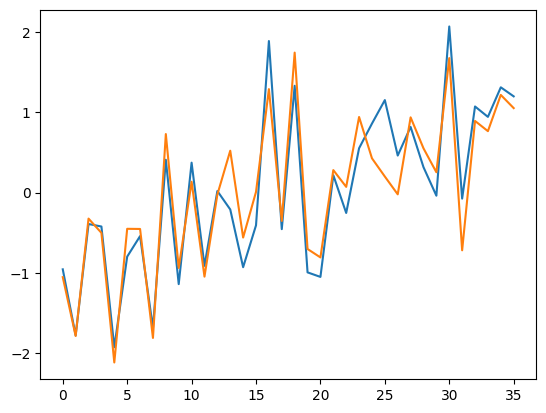

In [29]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSRegression


# Set up cartopy shape file so that it can distinguish between land and ocean
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    """
    Uses knowledge of land points to decide whether given location 
    is land or ocean. X is longitude and Y is latitude.
    """
    return land.contains(sgeom.Point(x, y))*1


def find_avg_ts(xarray, land_ocean_map):
    latitudes = xarray.latitude.values
    weights = np.cos(np.deg2rad(latitudes))
    weights_map = np.broadcast_to(weights, (144,73)).T
    temps = xarray.t2m.values
    temps_land = np.array([np.ma.masked_array(data=temps[i], mask=abs(land_ocean_map-1), fill_value=np.nan).filled() for i in range(len(temps))])
    land_weights = np.ma.masked_array(data=weights_map, mask=abs(land_ocean_map-1), fill_value=np.nan).filled()
    weighted_temps = np.multiply(temps_land, weights[np.newaxis, :, np.newaxis])
    weighted_temps_polar = weighted_temps[:,:21,:] # this gives north of 40    
    weighted_temps_polar = np.reshape(weighted_temps_polar, (432, 21*144))
    polar_temp_ts = np.nansum(weighted_temps_polar, axis=1)/np.nansum(land_weights[:21])
    polar_cal = np.reshape(polar_temp_ts, (36,12))
    polar_anoms = polar_cal - np.nanmean(polar_cal, axis=0)
    polar_anoms = np.reshape(polar_anoms, (432))
    polar_cal_ndjfma = np.nanmean([polar_cal[:,10], polar_cal[:,11], polar_cal[:,0], polar_cal[:,1], polar_cal[:,2], polar_cal[:,3]], axis=0)
    return(polar_cal_ndjfma)    

def find_corr_map(slp_map, ts):
    corr_map = []
    for lat in range(len(slp_map[0])):
        lat_row = []
        for lon in range(len(slp_map[0][0])):
            slp_ts = slp_map[:,lat,lon]
            correlation = stats.pearsonr(slp_ts, ts)[0]
            lat_row.append(correlation)
        corr_map.append(lat_row)
    return(corr_map)

# load datasets 
MonthlyNCEPpsl = xr.open_dataset('/home/disk/pna2/aodhan/MonthlyPSLNCEP.nc', decode_times=False)
MonthlyERA5tas = xr.open_dataset('/home/disk/pna2/aodhan/insitu_surface_products/ERA5_TAS_monthly_1965_2000.nc')

# swap the time axis on the SLP data
times = []
for yr in range(1949, 2024):
    if yr < 2023:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            date_time_obj = pd.to_datetime(str(yr) + '-' + month)
            times.append(date_time_obj)
    if yr == 2023:
        for month in ['01']:
            date_time_obj = pd.to_datetime(str(yr) + '-' + month)
            times.append(date_time_obj)
MonthlyNCEPpsl = MonthlyNCEPpsl.assign_coords(T=times)
MonthlyNCEPpsl_1965_2000 = MonthlyNCEPpsl.sel(T=slice('1965-01-01', '2000-12-01'))

# find land ocean map
land_ocean_map = []
for lat in MonthlyERA5tas.latitude:
    lat_line = []
    for lon in MonthlyERA5tas.longitude - 180:
        lat_line.append(is_land(lon, lat))
    land_ocean_map.append(lat_line)
land_ocean_map = np.array(land_ocean_map)
land_ocean_map = np.concatenate((land_ocean_map[:,72:], land_ocean_map[:,:72]), axis=1)

# find average wintertime temperature timeseries in polar region
polar_ts = find_avg_ts(MonthlyERA5tas, land_ocean_map)
polar_ts_mr = polar_ts - np.nanmean(polar_ts)
polar_ts_std = polar_ts_mr/np.nanstd(polar_ts_mr)

# find wintertime maps of slp
psl_all = MonthlyNCEPpsl_1965_2000.pressure.values
psl_cal = np.reshape(psl_all, (36,12,73,144))
psl_ndjfm = [psl_cal[:,10], psl_cal[:,11], psl_cal[:,0], psl_cal[:,1], psl_cal[:,2], psl_cal[:,3]]
psl_ndjfm = np.nanmean(psl_ndjfm, axis=0)
psl_cal_N = psl_ndjfm[:,:29,:]
psl_cal_N_mr = psl_cal_N - np.nanmean(psl_cal_N, axis=0)
psl_cal_N_std = psl_cal_N_mr/np.nanstd(psl_cal_N_mr, axis=0)

# find weighted
latitudes = MonthlyERA5tas.latitude.values
weights = np.cos(np.deg2rad(latitudes))[:29]
psl_cal_N_weighted = np.multiply(psl_cal_N_std, weights[np.newaxis,:,np.newaxis])


start = time.time()
Y = polar_ts_std.copy()
X = psl_cal_N_weighted.copy()

recreations_Y = []
recreations_X = []
pls = PLSRegression(n_components=2, scale=False)
pls.fit(X.reshape(36, (29*144)), Y)
N_dyn = pls.predict(X.reshape(36, (29*144)))[:,0]
end = time.time()
print('Time: ', end - start)
plt.plot(Y)
plt.plot(N_dyn)
    
polar_ts_regressed_out = polar_ts_std - N_dyn
print('Correlation: ', stats.pearsonr(polar_ts_std, N_dyn))
print('Polar_ts trend: ', stats.linregress(x=np.linspace(0,3.6,36), y=polar_ts_std)[0])
print('Dyn : ', stats.linregress(x=np.linspace(0,3.6,36), y=N_dyn)[0])
print('Non Dyn : ', stats.linregress(x=np.linspace(0,3.6,36), y=polar_ts_regressed_out)[0])
print('Dyn + Non-Dyn: ', stats.linregress(x=np.linspace(0,3.6,36), y=N_dyn)[0] + stats.linregress(x=np.linspace(0,3.6,36), y=polar_ts_regressed_out)[0])


In [16]:
import numpy as np
import glob
import xesmf as xe
import xarray as xr
import netCDF4 as nc
from scipy import stats
from sklearn.cross_decomposition import PLSRegression

def polar_winter_temps(tas_data_regridded):
    polar_temps = tas_data_regridded.sel(lat=slice(60, 90)).tas.values
    weights = np.cos(np.deg2rad(tas_data_regridded.lat.sel(lat=slice(60,90)).values))
    weighted_polar_temps = np.multiply(polar_temps, weights[np.newaxis,:,np.newaxis])
    avg_polar_temps = np.nansum(np.reshape(weighted_polar_temps, (1980, 12*144)), axis=1)/(np.nansum(weights)*144)
    avg_polar_temps_cal = np.reshape(avg_polar_temps, (165,12))
    ndjfm_polar_cal = [avg_polar_temps_cal[:,0], avg_polar_temps_cal[:,1], avg_polar_temps_cal[:,2], 
                       avg_polar_temps_cal[:,10], avg_polar_temps_cal[:,11]]
    ndjfm_polar_cal = np.swapaxes(ndjfm_polar_cal, 0,1)
    return(ndjfm_polar_cal)

def nh_winter_press(psl_data_regridded):
    nh_psl = psl_data_regridded.sel(lat=slice(20, 90)).psl.values
    nh_psl_cal = np.reshape(nh_psl, (165,12,np.shape(nh_psl)[1], np.shape(nh_psl)[2]))
    ndjfm_nh_psl_cal = [nh_psl_cal[:,0], nh_psl_cal[:,1], nh_psl_cal[:,2], nh_psl_cal[:,10], nh_psl_cal[:,11]]
    ndjfm_nh_psl_cal = np.swapaxes(ndjfm_nh_psl_cal, 0,1)
    return(ndjfm_nh_psl_cal)

def find_corr_map(slp_map, ts):
    print(np.shape(slp_map))
    corr_map = []
    for lat in range(len(slp_map[0])):
        lat_line = []
        for lon in range(len(slp_map[0][0])):
            slp_ts = slp_map[:,lat, lon]
            correlation = stats.pearsonr(slp_ts, ts)[0]
            lat_line.append(correlation)
        corr_map.append(lat_line)
    return(np.array(corr_map))

def dynamic_adjustment(n_comps, X, Y, X_test):
    recreations_Y = []
    recreations_X = []
    for iteration in range(n_comps):
        # find correlation map
        correlation_map = find_corr_map(X, Y)

        # project onto correlation map
        projection = np.array([np.nansum(np.multiply(X[i], correlation_map)) for i in range(0, len(X))])
        regression_ts = stats.linregress(x=projection, y=Y)
        recreation_ts = regression_ts[0]*projection + regression_ts[1]
        recreation_psl = []
        for lat_idx in range(len(X[0])):
            lat_line = []
            for lon_idx in range(len(X[0][0])):
                psl_ts_regression = stats.linregress(x=projection, y=X[:,lat_idx, lon_idx])
                pls_recreation = psl_ts_regression[0]*projection + psl_ts_regression[1]
                lat_line.append(pls_recreation)
            recreation_psl.append(lat_line)
        recreation_psl = np.array(recreation_psl)
        recreation_psl = np.swapaxes(recreation_psl, 0, 2)
        recreation_psl = np.swapaxes(recreation_psl, 1, 2)  
        recreations_X.append(recreation_psl)
        recreations_Y.append(recreation_ts)
        regressed_out_X = X - recreation_psl
        regressed_out_Y = Y - recreation_ts
        X = regressed_out_X
        Y = regressed_out_Y
    return(recreations_X, recreations_Y)


psl_files = glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/*')
tas_files = glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/IPSL-CM6A-LR/*')

psl_and_tas_files = []
for psl_file in psl_files:
    tas_file = psl_file[:48] + 'tas' + psl_file[51:]
    psl_and_tas_files.append([psl_file, tas_file])

# define times for final netcdf
winter_times = np.arange(1,826,1)

true_and_dynamic_ts = []
for file_set in psl_and_tas_files:
    #try:
    psl_data = xr.open_dataset(file_set[0])
    tas_data = xr.open_dataset(file_set[1])
    #except:
    #    print('Error opening file set: ', file_set)
    #print(file_set[0])
    # CMIP6 models must be regridded, below we define input and output grids
    latitudes = psl_data.lat.values # psl and tas have same grid
    longitudes = psl_data.lon.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    psl_data_regridded = regridder(psl_data)
    tas_data_regridded = regridder(tas_data)

    # get polar temperature during winter
    ndjfm_polar_temps_cal = polar_winter_temps(tas_data_regridded)

    # get NH pressure data during winter then weight this by latitude
    ndjfm_nh_psl_cal = nh_winter_press(psl_data_regridded)
    
    # preform cross validation of dynamic adjustment
    dynamical_contributions = []
    for x in range(165):
        temp_minus_one_winter = np.delete(ndjfm_polar_temps_cal, x, axis=0)
        temp_minus_one_winter = np.nanmean(temp_minus_one_winter, axis=1)
        pres_minus_one_winter = np.delete(ndjfm_nh_psl_cal, x, axis=0)
        pres_minus_one_winter = np.nanmean(pres_minus_one_winter, axis=1)
        
        # scale X train data 
        pres_minus_one_winter_ts = np.reshape(pres_minus_one_winter, (164,28,144))
        pres_minus_one_winter_mean = np.nanmean(pres_minus_one_winter_ts, axis=0)
        pres_minus_one_winter_mr = pres_minus_one_winter_ts - pres_minus_one_winter_mean
        pres_minus_one_winter_std = np.nanstd(pres_minus_one_winter_mr, axis=0)
        pres_minus_one_winter_scaled = pres_minus_one_winter_mr/pres_minus_one_winter_std

        # scale X test data
        pres_all_ts = np.nanmean(ndjfm_nh_psl_cal, axis=1)
        pres_all_mr = pres_all_ts - pres_minus_one_winter_mean
        pres_all_scaled = pres_all_mr/pres_minus_one_winter_std

        # weight X data by latitude
        weights = np.cos(np.deg2rad(psl_data_regridded.lat.sel(lat=slice(20,90)).values))
        pres_minus_one_winter_weighted = np.multiply(pres_minus_one_winter_scaled, weights[np.newaxis, :,np.newaxis])
        pres_all_scaled_weighted = np.multiply(pres_all_scaled, weights[np.newaxis, :,np.newaxis])

        # scale Y data
        temp_minus_one_winter_ts = np.reshape(temp_minus_one_winter, (164))
        temp_minus_one_winter_mean = np.nanmean(temp_minus_one_winter_ts, axis=0)
        temp_minus_one_winter_mr = temp_minus_one_winter_ts - temp_minus_one_winter_mean
        temp_minus_one_winter_std = np.nanstd(temp_minus_one_winter_mr, axis=0)
        temp_minus_one_winter_scaled = temp_minus_one_winter_mr/temp_minus_one_winter_std

        # define X and Y data
        X = np.reshape(pres_minus_one_winter_weighted, (164, 28,144))
        Y = np.reshape(temp_minus_one_winter_scaled, (164))
        
        # create PLS model with 2 components
        dynamic_adjustment(n_comps=2, X=X, Y=Y, X_test=pres_all_scaled_weighted)

        # deploy on all pressure data
        all_pressures = np.reshape(pres_all_scaled_weighted, (165, 28,144))
        temp_dynamical = dynamic_adjustment.predict(all_pressures)

        # unscale the data so that units are again in K
        temp_dynamical_multiplied_by_std = temp_dynamical#*temp_minus_one_winter_std
        temp_dynamical_unscaled = temp_dynamical_multiplied_by_std + temp_minus_one_winter_mean
        dynamical_contributions.append(temp_dynamical_unscaled)

    # find mean dynamical contribution over all cross validations
    dynamical_mean = np.nanmean(dynamical_contributions, axis=0)[:,0]

    # reshape the raw polar timeseries
    polar_temp_timeseries = np.nanmean(ndjfm_polar_temps_cal, axis=1)

    plt.plot(polar_temp_timeseries)  
    plt.plot(dynamical_mean)
    

    
    break

    # create a netcdf file
    sotrage_path = '/home/disk/pna2/aodhan/CMIP6/historical_dynamical_ts'
    model = file_set[0].split('/')[7]
    simulation = file_set[0].split('/')[8]
    fileName = sotrage_path + '/' + model + '/' + simulation + '.nc'
    ds = nc.Dataset(fileName, 'w', format='NETCDF4')
    
    DynamicalContribution = ds.createDimension('DynamicalContribution', 2)
    time = ds.createDimension('time', 825)

    # Add variables to dimensions
    DynamicalContribution = ds.createVariable('DynamicalContribution', int, ('DynamicalContribution',))
    time = ds.createVariable(varname='time', datatype='S1', dimensions=('time',))
    timeseries = ds.createVariable('temp', 'f4', ('DynamicalContribution', 'time'))

    # Assing values to variables
    DynamicalContribution[:] = [0,1]
    time[:] = winter_times
    timeseries[:] = [polar_temp_timeseries, dynamical_mean]

    # close netcdf    
    ds.close()



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  UserWarning,


(164, 28, 144)
(164, 28, 144)


AttributeError: 'function' object has no attribute 'predict'

In [2]:
psl_and_tas_files

[['/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r8i1p1f1',
  '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/IPSL-CM6A-LR/r8i1p1f1'],
 ['/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r2i1p1f1',
  '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/IPSL-CM6A-LR/r2i1p1f1'],
 ['/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r30i1p1f1',
  '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/IPSL-CM6A-LR/r30i1p1f1'],
 ['/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r31i1p1f1',
  '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/IPSL-CM6A-LR/r31i1p1f1'],
 ['/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r3i1p1f1',
  '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/IPSL-CM6A-LR/r3i1p1f1'],
 ['/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r6i1p1f1',
  '/home/disk/pna2/aodhan/CMIP6/historical_mo

Opened file set:  /home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r8i1p1f1


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  UserWarning,


Regridded
found polar press and temp
found dynamical contribution.


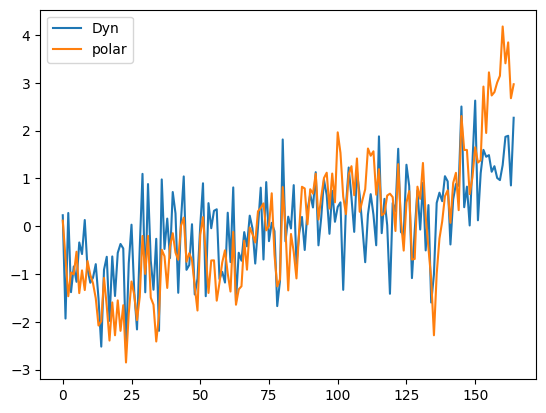

In [25]:
import numpy as np
import glob
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import os
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

def polar_winter_temps(tas_data_regridded):
    polar_temps = tas_data_regridded.sel(lat=slice(60, 90)).tas.values
    weights = np.cos(np.deg2rad(tas_data_regridded.lat.sel(lat=slice(60,90)).values))
    weighted_polar_temps = np.multiply(polar_temps, weights[np.newaxis,:,np.newaxis])
    avg_polar_temps = np.nansum(np.reshape(weighted_polar_temps, (1980, 12*144)), axis=1)/(np.nansum(weights)*144)
    avg_polar_temps_cal = np.reshape(avg_polar_temps, (165,12))
    ndjfm_polar_cal = [avg_polar_temps_cal[:,0], avg_polar_temps_cal[:,1], avg_polar_temps_cal[:,2], 
                       avg_polar_temps_cal[:,10], avg_polar_temps_cal[:,11]]
    ndjfm_polar_cal = np.swapaxes(ndjfm_polar_cal, 0,1)
    return(ndjfm_polar_cal)

def nh_winter_press(psl_data_regridded):
    nh_psl = psl_data_regridded.sel(lat=slice(20, 90)).psl.values
    nh_psl_cal = np.reshape(nh_psl, (165,12,np.shape(nh_psl)[1], np.shape(nh_psl)[2]))
    ndjfm_nh_psl_cal = [nh_psl_cal[:,0], nh_psl_cal[:,1], nh_psl_cal[:,2], nh_psl_cal[:,10], nh_psl_cal[:,11]]
    ndjfm_nh_psl_cal = np.swapaxes(ndjfm_nh_psl_cal, 0,1)
    return(ndjfm_nh_psl_cal)

# find all potential models
psl_models = glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/*')

for model_path in psl_models[0:1]:
    model_paths = model_path + '/*'
    psl_files = glob.glob(model_paths)

    psl_and_tas_files = []
    for psl_file in psl_files:
        tas_file = psl_file[:48] + 'tas' + psl_file[51:]
        psl_and_tas_files.append([psl_file, tas_file])

    # define times for final netcdf
    winter_times = np.arange(1850,2015,1)

    true_and_dynamic_ts = []
    for file_set in psl_and_tas_files:
        try:
            psl_data = xr.open_dataset(file_set[0])
            psl_data = psl_data.sel(time=slice('1850-01-01', '2015-01-01'))
            tas_data = xr.open_dataset(file_set[1])
            tas_data = tas_data.sel(time=slice('1850-01-01', '2015-01-01'))
            if len(psl_data.time) != len(tas_data.time):
                continue
            if len(psl_data.time) != 1980:
                continue
            print('Opened file set: ', file_set[0])
        except:
            print('Error opening file set: ', file_set)
            continue

        # CMIP6 models must be regridded, below we define input and output grids
        latitudes = psl_data.lat.values # psl and tas have same grid
        longitudes = psl_data.lon.values
        InputGrid = {"lon": longitudes, "lat": latitudes}
        OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
        regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
        psl_data_regridded = regridder(psl_data)
        tas_data_regridded = regridder(tas_data)

        print('Regridded')
        # get polar temperature during winter
        ndjfm_polar_temps_cal = polar_winter_temps(tas_data_regridded)

        # get NH pressure data during winter then weight this by latitude
        ndjfm_nh_psl_cal = nh_winter_press(psl_data_regridded)
        
        print('found polar press and temp')
        # preform cross validation of dynamic adjustment
        dynamical_contributions = []
        for x in range(165):
            temp_minus_one_winter = np.delete(ndjfm_polar_temps_cal, x, axis=0)
            temp_minus_one_winter = np.nanmean(temp_minus_one_winter, axis=1)
            pres_minus_one_winter = np.delete(ndjfm_nh_psl_cal, x, axis=0)
            pres_minus_one_winter = np.nanmean(pres_minus_one_winter, axis=1)
            
            # scale X train data 
            pres_minus_one_winter_ts = np.reshape(pres_minus_one_winter, (164,28,144))
            pres_minus_one_winter_mean = np.nanmean(pres_minus_one_winter_ts, axis=0)
            pres_minus_one_winter_mr = pres_minus_one_winter_ts - pres_minus_one_winter_mean
            pres_minus_one_winter_std = np.nanstd(pres_minus_one_winter_mr, axis=0)
            pres_minus_one_winter_scaled = pres_minus_one_winter_mr/pres_minus_one_winter_std

            # scale X test data
            pres_all_ts = np.nanmean(ndjfm_nh_psl_cal, axis=1)
            pres_all_mr = pres_all_ts - pres_minus_one_winter_mean
            pres_all_scaled = pres_all_mr/pres_minus_one_winter_std

            # weight X data by latitude
            weights = np.cos(np.deg2rad(psl_data_regridded.lat.sel(lat=slice(20,90)).values))
            pres_minus_one_winter_weighted = np.multiply(pres_minus_one_winter_scaled, weights[np.newaxis, :,np.newaxis])
            pres_all_scaled_weighted = np.multiply(pres_all_scaled, weights[np.newaxis, :,np.newaxis])

            # scale Y data
            temp_minus_one_winter_ts = np.reshape(temp_minus_one_winter, (164))
            temp_minus_one_winter_mean = np.nanmean(temp_minus_one_winter_ts, axis=0)
            temp_minus_one_winter_mr = temp_minus_one_winter_ts - temp_minus_one_winter_mean
            temp_minus_one_winter_std = np.nanstd(temp_minus_one_winter_mr, axis=0)
            temp_minus_one_winter_scaled = temp_minus_one_winter_mr/temp_minus_one_winter_std

            # define X and Y data
            X = np.reshape(pres_minus_one_winter_weighted, (164, 28*144))
            Y = np.reshape(temp_minus_one_winter_scaled, (164))
            
            # create PLS model with 2 components
            pls = PLSRegression(n_components=2, scale='False')
            pls.fit(X, Y)

            # deploy on all pressure data
            all_pressures = np.reshape(pres_all_scaled_weighted, (165, 28*144))
            temp_dynamical = pls.predict(all_pressures)

            # unscale the data so that units are again in K
            temp_dynamical_multiplied_by_std = temp_dynamical*temp_minus_one_winter_std
            dynamical_contributions.append(temp_dynamical_multiplied_by_std)

        print('found dynamical contribution.')
        # find mean dynamical contribution over all cross validations
        dynamical_mean = np.nanmean(dynamical_contributions, axis=0)[:,0]

        # reshape the raw polar timeseries
        polar_temp_timeseries = np.nanmean(ndjfm_polar_temps_cal, axis=1)
        plt.plot(dynamical_mean, label='Dyn')
        plt.plot(polar_temp_timeseries - np.nanmean(polar_temp_timeseries), label='polar')
        plt.legend()
        break
        # create a netcdf file
        storage_path = '/home/disk/pna2/aodhan/CMIP6/historical_dynamical_ts'
        completed_models = glob.glob(storage_path + '/*')
        completed_model_strings = [completed_models[i].split('/')[7] for i in range(0, len(completed_models))]
        model = file_set[0].split('/')[7]
        if model not in completed_model_strings:
            os.mkdir(storage_path + '/' + model)
        simulation = file_set[0].split('/')[8]
        fileName = storage_path + '/' + model + '/' + simulation + '.nc'
        ds = nc.Dataset(fileName, 'w', format='NETCDF4')
        
        DynamicalContribution = ds.createDimension('DynamicalContribution', 2)
        time = ds.createDimension('time', 165)

        # Add variables to dimensions
        DynamicalContribution = ds.createVariable('DynamicalContribution', int, ('DynamicalContribution',))
        time = ds.createVariable(varname='time', datatype=int, dimensions=('time',))
        timeseries = ds.createVariable('temp', 'f4', ('DynamicalContribution', 'time'))

        # Assing values to variables
        DynamicalContribution[:] = [0,1]
        time[:] = winter_times
        timeseries[:] = [polar_temp_timeseries, dynamical_mean]

        # close netcdf    
        ds.close()
    break


In [21]:
dynamical_mean_2 = dynamical_mean

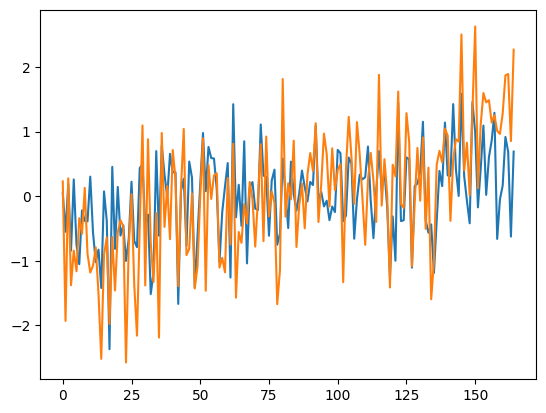

In [26]:
plt.plot(dynamical_mean_2)
plt.plot(dynamical_mean)